# Predicting Cell Behavior from Cell Morphology during Cell-Cell Shear
<br> 
<br> 
<center>ECE594N HW Shapes </center>
<br> 
<center>$\color{#003660}{\text{Samuel Feinstein, Amil Khan, Lauren Washington, Alice Mo}}$</center>
<br>
<center>$\color{#003660}{\text{Data from Ehsan Sadeghipour, Miguel A Garcia, William James Nelson, Beth L Pruitt (2018) Shear-induced damped}}$</center>
<center>$\color{#003660}{\text{oscillations in an epithelium depend on actomyosin contraction and E-cadherin cell adhesion eLife 7:e39640.}}$</center>
<br> 

<center><img src="figs/Cropped_Regions@4x.png" width=800px alt="default"/></center>
<center>Confluent MDCK cells on a MEMS device with segmentation by Cellpose </center>
<br> 
<center>Image from Liam Dow </center>

# Graphical Abstract
<br> 
<br> 
<center><img src="figs/Graphical_Abstract_V1@4x.png" width=800px alt="default"/></center>
<br> 
<center>Image from Liam Dow </center>

# 1. Introduction and Motivation

Cell-cell shear, or the action of cells sliding past each other, has roles in development, disease, and wound healing. Throughout development cells are moving past each other in every stage of development. These biomechanical cues have influences on differentiation, cell shape, behavior, the proteome, and the transcriptome. Previous research on shear focused on fluid shear so in this paper they focused on cell-cell shear which has been well characterized. Epithelial cells known as MDCK cells were used on a MEMS device which can be precisely displaced to create consistent cell-cell shear forces. Using new segmentation and machine learning techniques we are reanalyzing the data to use the changes in cell shape to predict cell behavior/migration.

This research looked at examining cells ability to sense and respond to the shear force that occurs between cells during morphogenesis and tissue growth. After testing the exogenous shear on different parts of the cellular system, the researchers observed oscillatory movement across the epithelium that gradually dampened. Using a model of epithelium mechanics along with the data found in the study, they found that there was an imbalance of forces in the epithelium that is impacted by the oscillatory cell movements and actin filaments because of the shear-induced mechanical event at the shear plane affecting through the actomyosin contraction.

Studies with machine learning on cell migration have involved the overall migration and regional migration patterns of cells, the latter of which has been studied for the invasiveness of tumor cells using finite element analysis for smoother fitting (Vong 2023). In-vitro migration assays that incorporate the cell-cell contacts provide a closer comparison to the in-vivo environment (Kramer 2013). Current machine learning models include Usiigaci which visualizes and tracks the cell movement and morphology with microscopy segmentation (Tsai 2019). ML research involving molecular interactions faces challenges in data complexity, as noted in ML research on transcriptomes by  Zeng 2022. By studying cell behavior with machine learning of cell-cell shear forces, we can determine and predict the effect of the cell shape on its behavior.

<br> 
<br> 
<center><img src="figs/Shear_schematic@4x.png" width=800px alt="default"/></center>
<br> 
<center>Schematic of the Shear Device from Liam Dow </center>

## Install and Import Packages
If you run into any issues involving `ModuleNotFoundError: No module named 'tensorflow'`, then run the first cell below. Otherwise, run the second one and you should be good to go!

In [146]:
%%bash
# conda install scikit-image pandas matplotlib
# conda install -y "jupyterlab>=3" "ipywidgets>=7.6"
# pip install geomstats read-roi


In [48]:
import numpy as np
import skimage
import pandas as pd
import matplotlib.pyplot as plt
# import cv2

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.geometry.discrete_curves import DiscreteCurves
from geomstats.geometry.euclidean import Euclidean

from read_roi import read_roi_file
from read_roi import read_roi_zip



plt.rcParams["figure.dpi"] = 300
%config InlineBackend.figure_format='retina'

---

## Load Data


In [3]:
img   = skimage.io.imread("OG/BP-01_img_000000000_TXR_000.tif", as_gray=True)
label = skimage.io.imread("Labels/BP-01_img_000000000_TXR_000_label.png", as_gray=True)
data  = pd.read_csv("Data/BP-01_img_000000000_TXR_000_Erosion_0px_Channel_1.csv")

# Load ROI ZIP File
roi   = read_roi_zip("ROIs/BP-01_img_000000000_TXR_000_Erosion_0px_RoiSet.zip") 

## Visualize the Data 
Here we use `matplotlib` to visualize the `img` loaded above. We also plotted the centers of each labeled cell using `data`.

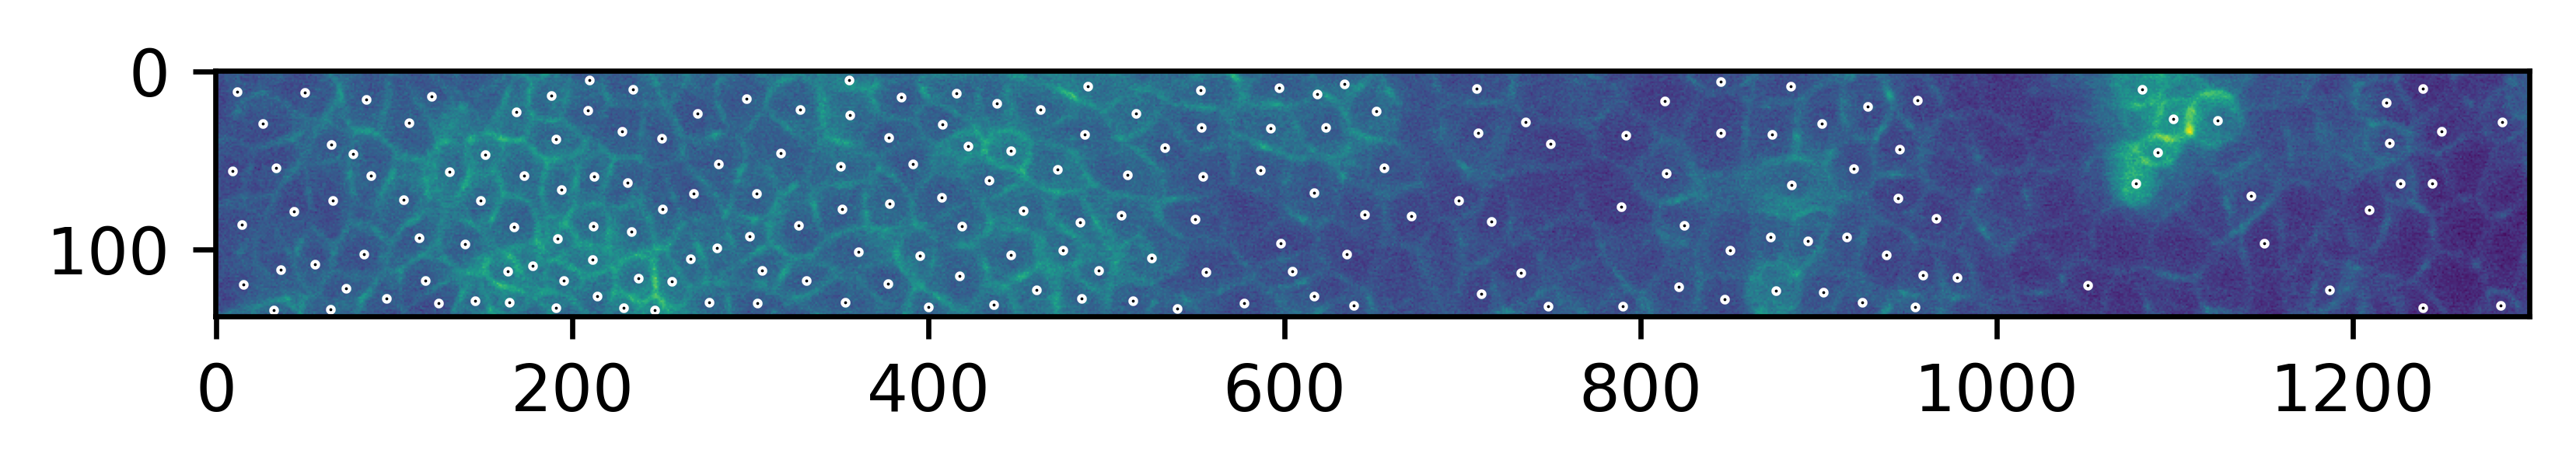

In [4]:
plt.imshow(img)
plt.scatter(data.X, data.Y, c='black', s=0.25, edgecolors='white')


## Visualizing the difference between 1 and 30

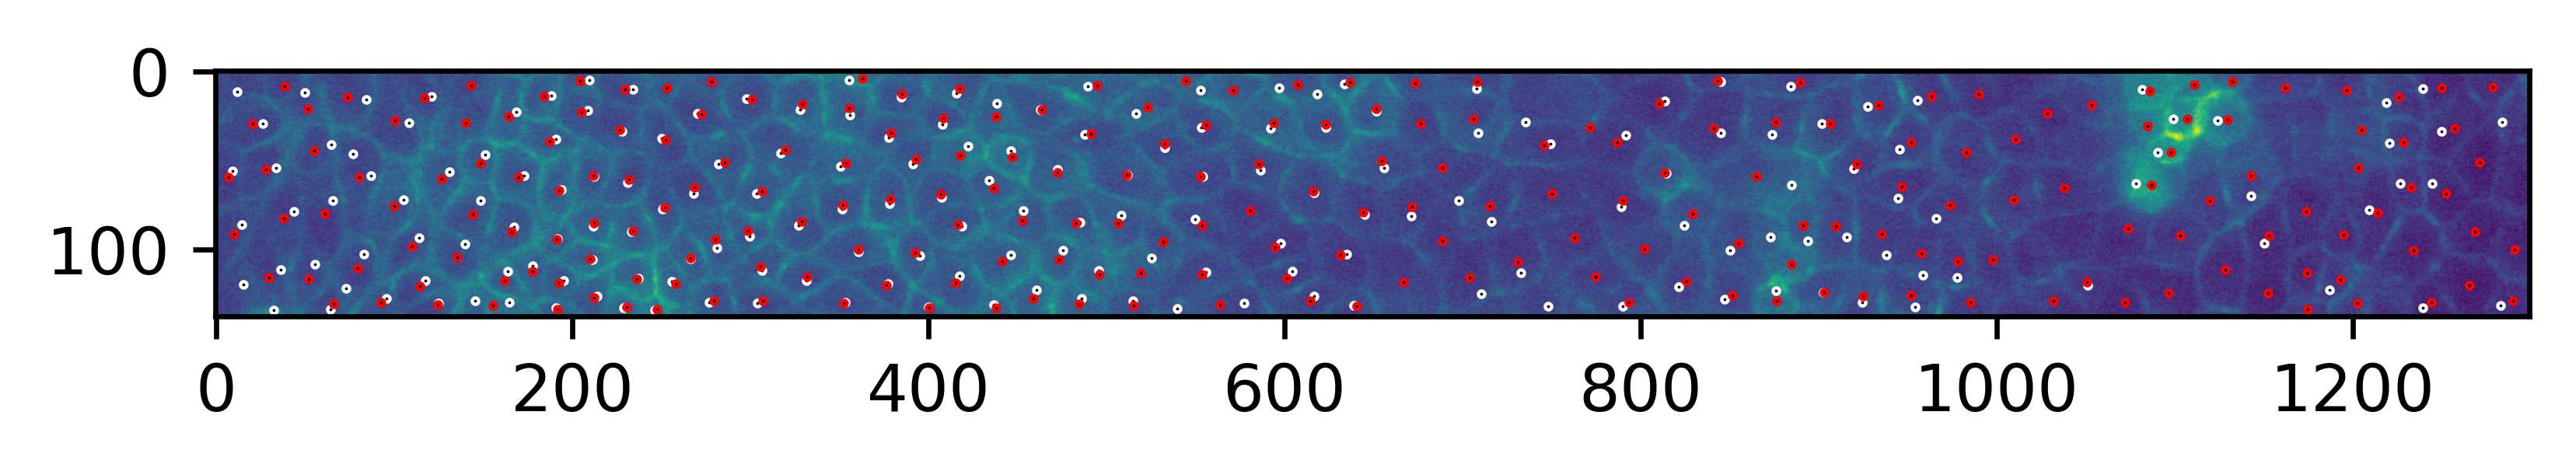

In [5]:
img2   = skimage.io.imread("OG/BP-01_img_000000030_TXR_000.tif")
data2  = pd.read_csv("Data/BP-01_img_000000030_TXR_000_Erosion_0px_Channel_1.csv")
plt.imshow(img2)
plt.scatter(data.X, data.Y, c='black', s=0.25, edgecolors='white')
plt.scatter(data2.X, data2.Y, c='black', s=0.25, edgecolors='red')

__Notes__
The red dots represent the position at time 30. Some have a significant change when comparing from the initial white point. Would it be worth looking at the displacement? What should we look at? The shape of the curves?

## Visualize the ROI
The `roi` is loaded as an `OrderedDict`. What this means is the dictionary, or key-value pairs, are ordered. For us, its from 001 to $N$ where $N$ represents the number of labeled cells.

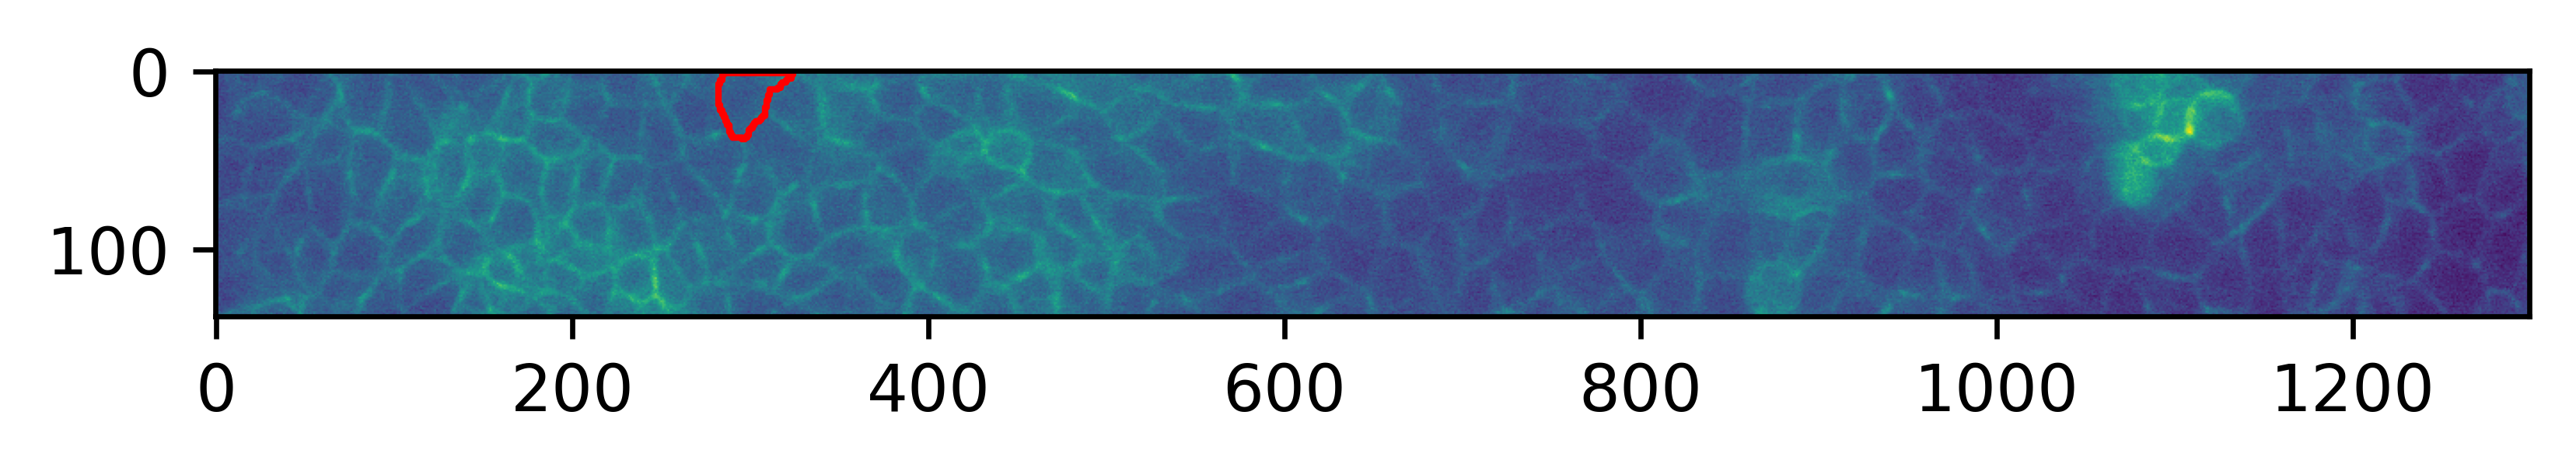

In [8]:
plt.imshow(img)
plt.plot(roi['019']['x'], roi['019']['y'], c='red', linewidth=1)

### Helper Functions for Plotting

In [42]:
def vis_roi(img, roi, cellNum: str ):
    """
    Visualize Entire Image and ROI
    
    PARAMS
    ------
    
    img: ARRAY raw image to visualize
    
    roi: DICT  Region of Interest to visualize
    
    cellNum: STRING Which cell number to visualize
    
    
    RETURNS
    ------
    
    Matplotlib plot with roi overlayed
    """
    if len(cellNum) < 3:
        raise Exception("Cell Number requires three digit (000) format, i.e., 019.")
    print("-"*30)
    print(f'Choose from 001 to {len(roi)}')
    print(f'Selected: Cell Label {cellNum}')
    print("-"*30)
    plt.imshow(img)
    plt.plot(roi[str(cellNum)]['x'], roi[str(cellNum)]['y'], c='red', linewidth=1)

------------------------------
Choose from 001 to 196
Selected: Cell Label 009
------------------------------


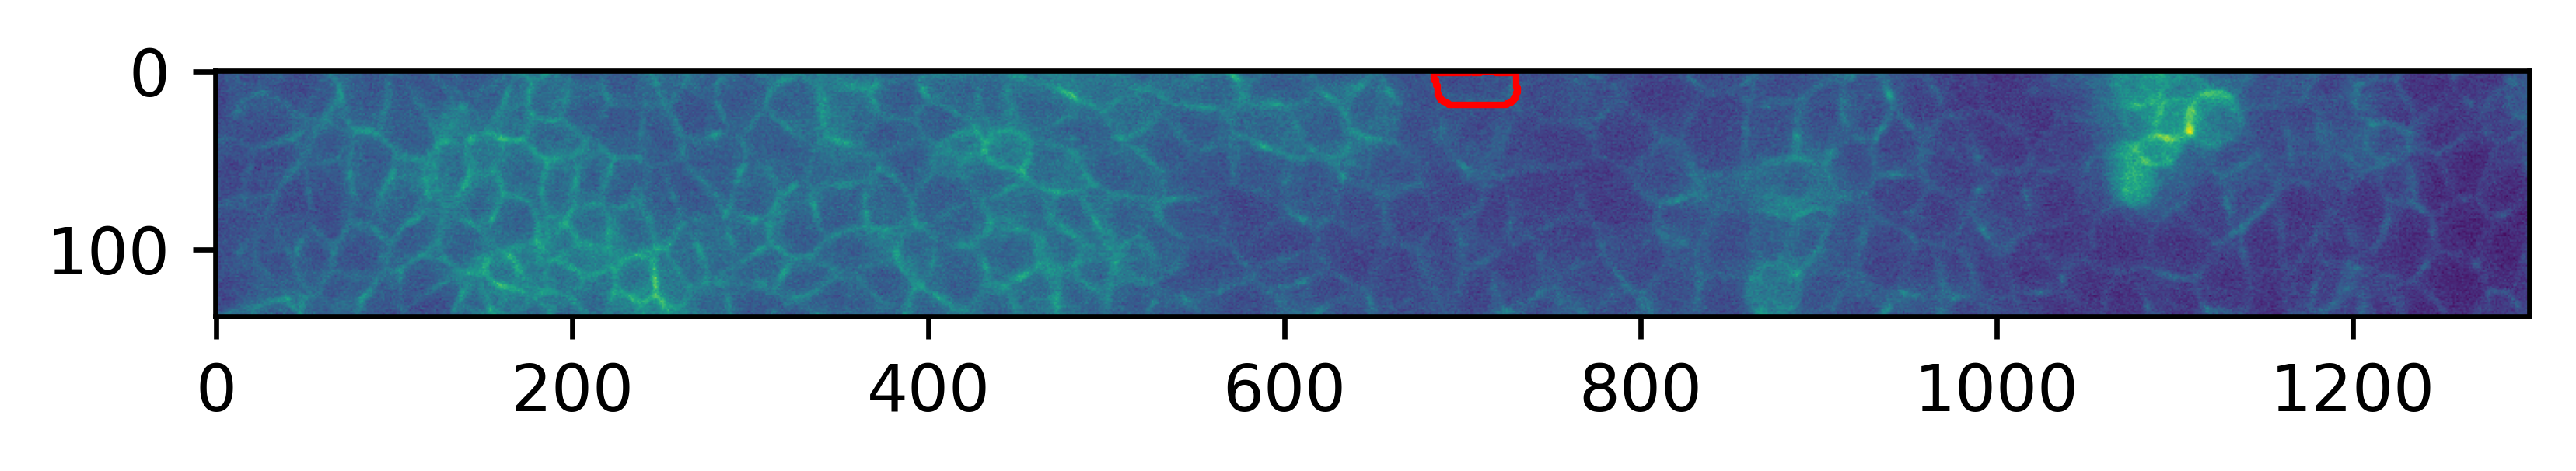

In [44]:
vis_roi(img, roi, '009')

In [45]:
def roiContour(roi, cellNum: str ):
    """
    Visualize ONLY ROI
    
    PARAMS
    ------
    
    
    roi: DICT  Region of Interest to visualize
    
    cellNum: STRING Which cell number to visualize
    
    
    RETURNS
    ------
    
    Matplotlib Line plot for ROI
    """
    print("-"*30)
    print(f'Choose from 001 to {len(roi)}')
    print(f'Selected: Cell Label {cellNum}')
    print("-"*30)
    # plt.imshow(img)
    plt.plot(roi[str(cellNum)]['x'], roi[str(cellNum)]['y'], c='red', linewidth=1)

------------------------------
Choose from 001 to 196
Selected: Cell Label 001
------------------------------


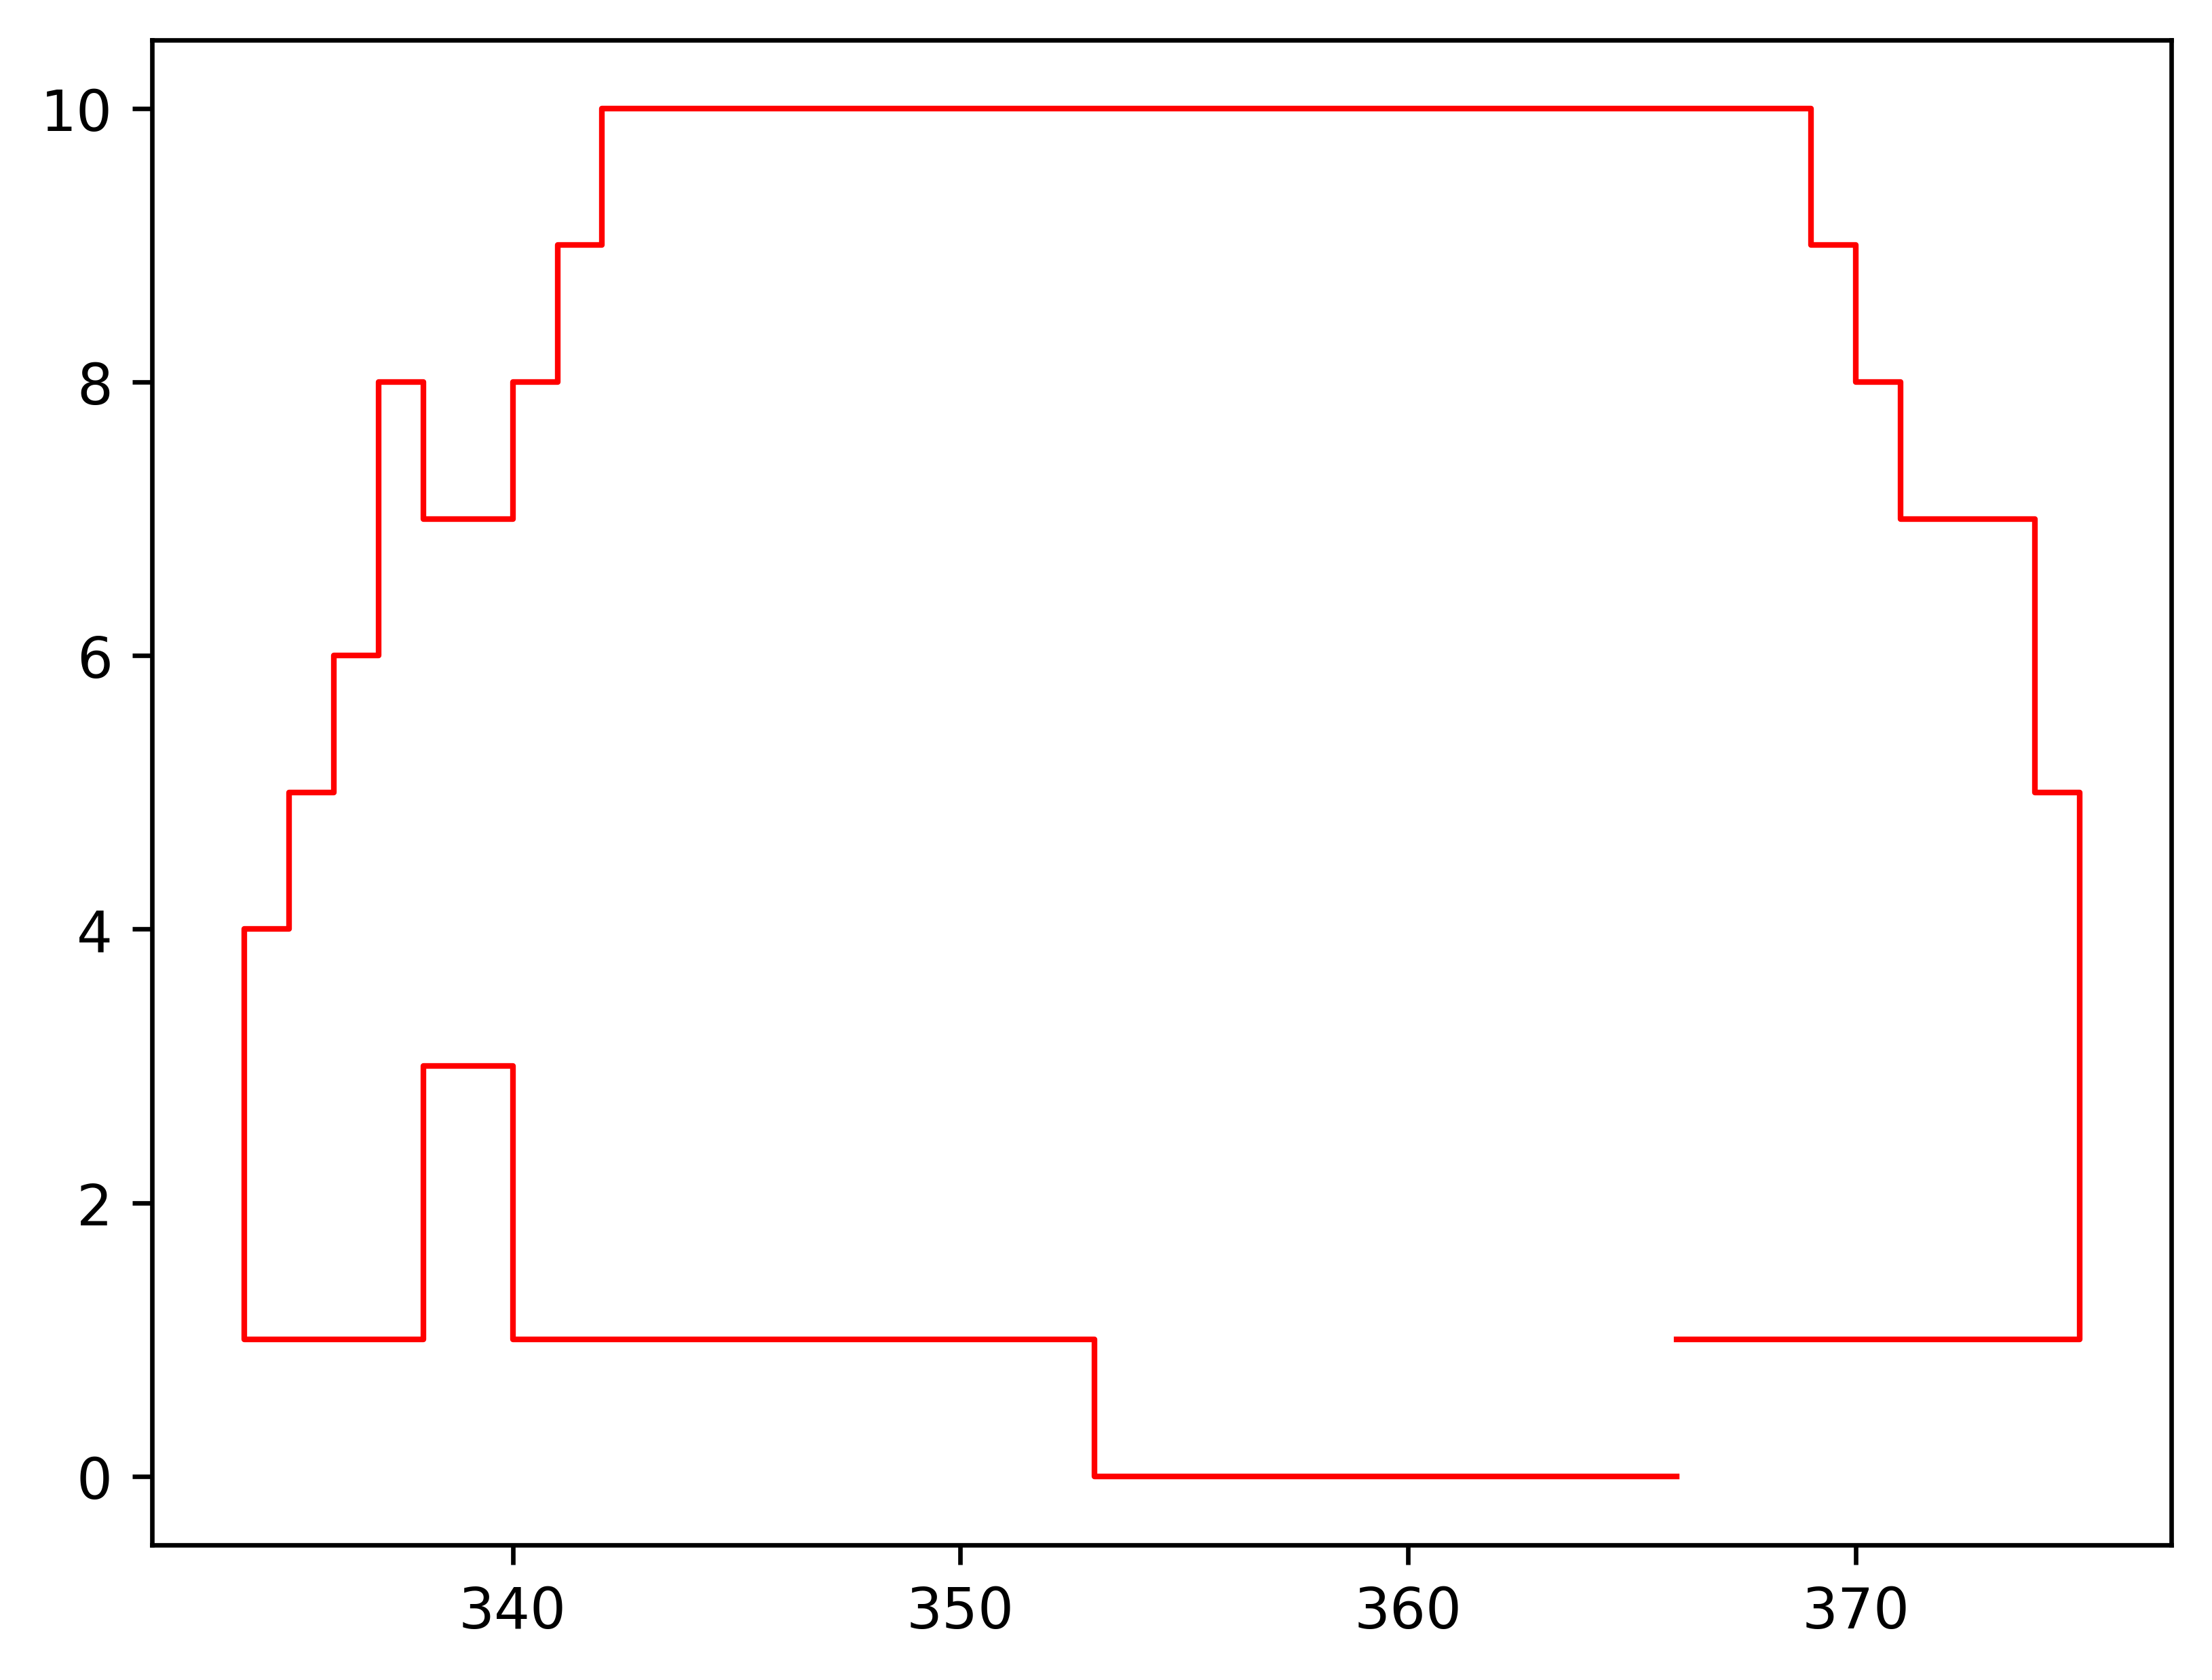

In [32]:
roiContour(roi, '001')

__NOTE__ So looks like we might need to close these curves. I am not sure if this needs to be addressed for sure, but definitely something we can postprocess and do within Python.

## Use Geomstats for Projecting Data on a Manifold

### Preprocess Data

In [133]:
def get_curve(roi: dict[str, list[int]]):
    """
    Return ROI Curve for an image using geomstats backend
    
    Parameters
    ----------
    roi : dict, Cell Number as the key, coordinates as xy
    """
    curves = []
    for cell in roi.keys():
        curves.append(np.column_stack((roi[cell]['x'], roi[cell]['y'])))
    return curves


In [132]:
img_roi = get_curve(roi)
len(img_roi)

196

Text(0.5, 1.0, 'Verify ROI Curve')

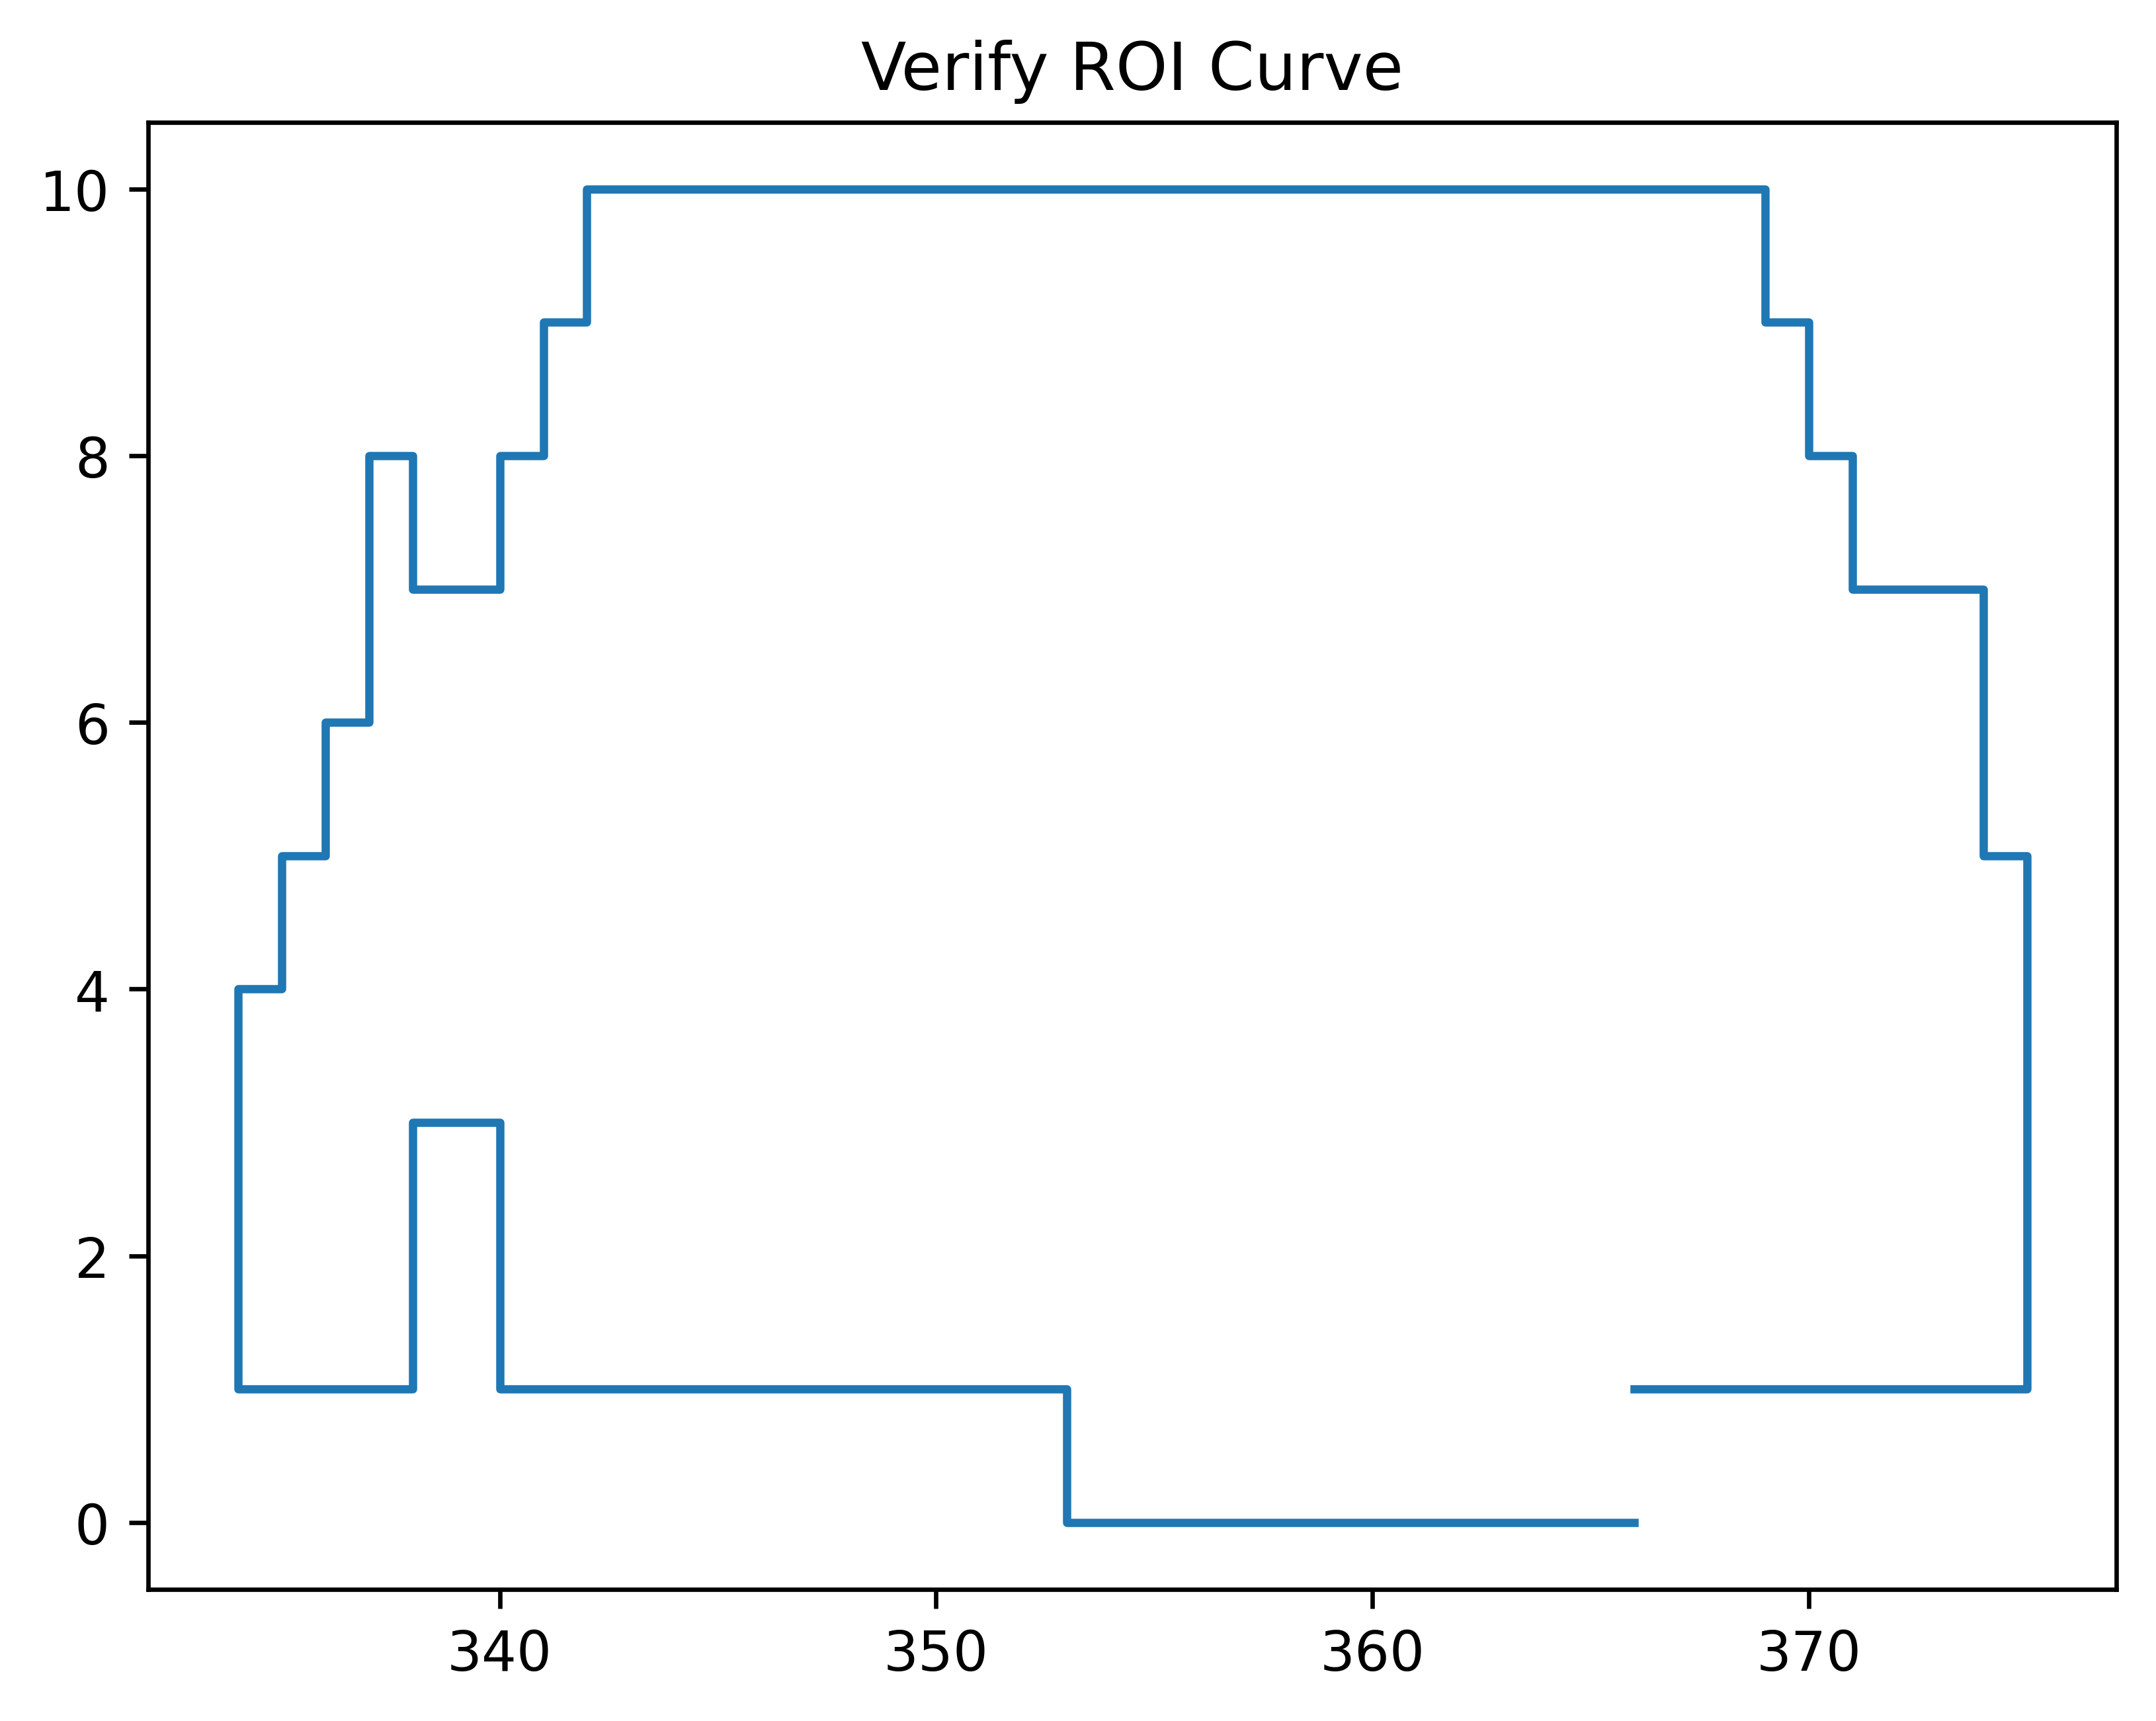

In [121]:
# Verify that get_curve correctly parsed the rois
test_roi = img_roi[0]
plt.plot(test_roi[:,0], test_roi[:,1])
plt.title("Verify ROI Curve")

In [80]:
def interpolate_dicrete_curve(curve, n_sampling_points):
    """
    Interpolate a discrete curve so that it gets a given number of sampling points.

    Parameters
    ----------
    curve : array-like, shape=[n_points, 2]
    n_sampling_points : int
    
    Returns
    -------
    interpolation : array-like, shape=[n_sampling_points, 2]
       Discrete curve with n_sampling_points
    """
    old_length = curve.shape[0]
    interpolation = np.zeros((n_sampling_points, 2))
    incr = old_length / n_sampling_points
    pos = np.array(0.0, dtype=np.float32)
    for i in range(n_sampling_points):
        index = int(np.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return gs.array(interpolation, dtype=gs.float32)

In [118]:
r2 = Euclidean(2)

planar_curves_space = DiscreteCurves(r2)

result = planar_curves_space.belongs(img_roi)
gs.all(result)

True

#### Curve Interpolation
Here we illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one.

(382.9839859008789, 407.0960006713867, 87.45, 121.55)

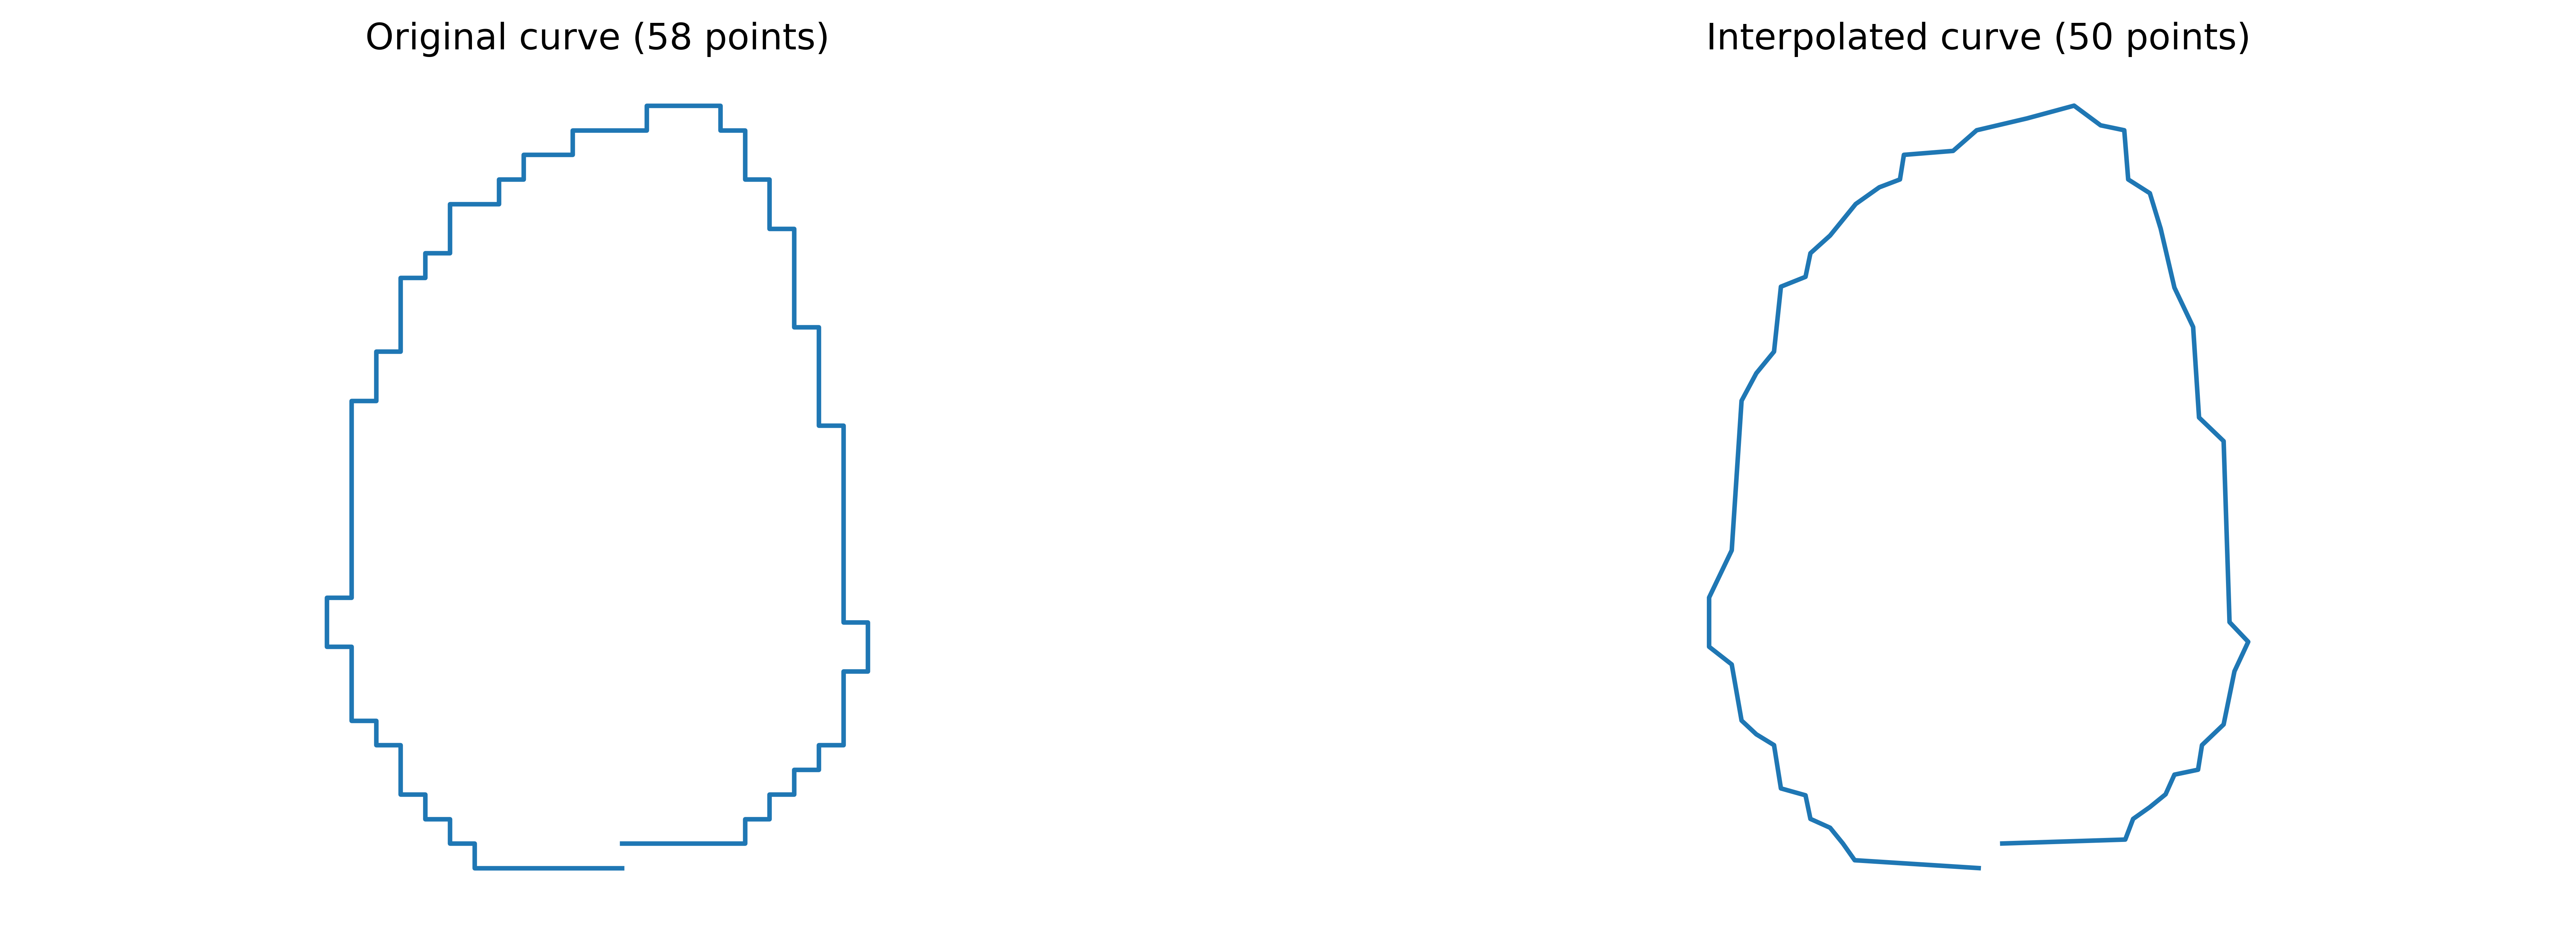

In [131]:
k_sampling_points = 50

cell_rand = img_roi[gs.random.randint(len(img_roi))]
cell_interpolation = interpolate_dicrete_curve(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

---

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import geomstats.backend as gs
import pandas as pd


def load_cells():
    """Load cell data.
    This cell dataset contains cell boundaries of mouse osteosarcoma
    (bone cancer) cells. The dlm8 cell line is derived from dunn and is more
    aggressive as a cancer. The cells have been treated with one of three
    treatments : control (no treatment), jasp (jasplakinolide)
    and cytd (cytochalasin D). These are drugs which perturb the cytoskelet
    of the cells.
    Returns
    -------
    cells : list of 650 planar discrete curves
        Each curve represents the boundary of a cell in counterclockwise order,
        their lengths are not necessarily equal.
    cell_lines : list of 650 strings
        List of the cell lines of each cell (dlm8 or dunn).
    treatments : list of 650 strings
        List of the treatments given to each cell (control, cytd or jasp).
    """
    with open(CELLS_PATH) as cells_file:
        cells = cells_file.read().split("\n\n")
    for i, cell in enumerate(cells):
        cell = cell.split("\n")
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.cast(gs.array(curve), gs.float32)
    with open(CELL_LINES_PATH) as cell_lines_file:
        cell_lines = cell_lines_file.read().split("\n")
    with open(CELL_TREATMENTS_PATH) as treatments_file:
        treatments = treatments_file.read().split("\n")
    return cells, cell_lines, treatments

INFO: Using numpy backend


# We need to ensure there are no duplicate sampling points in our shapes

In [ ]:
#Code snippet to remove identical consecutive sampling points, provided by Prof. Nina Miolane
def _remove_consecutive_duplicates(curve, tol=1e-2):
    """Preprocess curve to ensure that there are no consecutive and identical sampling points.

    Returns
    -------
    curve : discrete curve
    """
    dist = curve[1:] - curve[:-1]
    dist_norm = gs.sqrt(gs.sum(dist**2, axis=1))

    if gs.any(dist_norm < tol):
        for i in range(len(curve) - 2):
            if gs.sqrt(gs.sum((curve[i + 1] - curve[i]) ** 2, axis=0)) < tol:
                curve[i + 1] = (curve[i] + curve[i + 2]) / 2

    return curve

# References

Vong, Chun Kiet, et al. "Quantification of Tumoursphere Migration with a physics‐based machine learning method." *Cytometry Part A* (2023).

Kramer, Nina, et al. "In vitro cell migration and invasion assays." *Mutation Research/Reviews in Mutation Research* 752.1 (2013): 10-24.

Tsai, Hsieh-Fu, et al. "Usiigaci: Instance-aware cell tracking in stain-free phase contrast microscopy enabled by machine learning." *SoftwareX 9* (2019): 230-237.

Zeng, Zexian, et al. "Statistical and machine learning methods for spatially resolved transcriptomics data analysis." *Genome biology* 23.1 (2022): 1-23.